In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import talib as ta
import matplotlib.pyplot as plt
import plotly.graph_objects as go

##### 1.- Bajada de datos de Yahoo Finance

In [2]:
data_btc = yf.download('BTC-USD', period="10y", interval="1d")
data_btc.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,,
2015-02-13 00:00:00+00:00,235.427002,235.427002,240.259003,221.261993,221.968994,42744400
2015-02-14 00:00:00+00:00,257.321014,257.321014,259.808014,235.528000,235.528000,49732500
2015-02-15 00:00:00+00:00,234.824997,234.824997,265.610992,227.684006,257.506989,56552400
2015-02-16 00:00:00+00:00,233.843002,233.843002,239.520996,229.022003,234.824997,28153700
2015-02-17 00:00:00+00:00,243.610001,243.610001,245.774994,232.313995,233.421997,27363100


##### 2.- Cálculo del Indicador MACD

Se calcula el indicador MACD con lo valores por defecto [12, 26, 9]

El indicador MACD (Moving Average Convergence Divergence) se compone de tres elementos principales:

- **Línea MACD:** Es la diferencia entre dos medias móviles exponenciales (EMA) de diferentes periodos. Generalmente, se utilizan una EMA de 12 periodos y una EMA de 26 periodos.
- **Línea de Señal:** Es una media móvil exponencial de la línea MACD, generalmente de 9 periodos.
- **Histograma MACD:** Es la diferencia entre la línea MACD y la línea de señal. Este histograma se utiliza para identificar la fuerza de la tendencia.

In [3]:
data = data_btc.copy()

MACD_FAST = 12
MACD_SLOW = 26
MACD_SIGNAL = 9

close_prices = data['Close'].astype(float).values
close_prices = close_prices.ravel()  # También puedes usar .flatten()

data['macd'], data['macdSignal'], data['macdHist'] = ta.MACD(close_prices,fastperiod=MACD_FAST, slowperiod=MACD_SLOW, signalperiod=MACD_SIGNAL)

##### 3.- Cálculo de la Estrategia

La estrategia principal que se utiliza con el indicador MACD para comprar o vender se basa en las señales de cruce entre la línea MACD y la línea de señal. De manera que crearemos una nueva columna en el dataframe que marcaremos como 0 o 1, venta o compra, en función de lo siguiente:

- **Señal de Compra**: Ocurre cuando la línea MACD cruza por encima de la línea de señal. Esto indica una posible tendencia alcista.
- **Señal de Venta:** Ocurre cuando la línea MACD cruza por debajo de la línea de señal. Esto indica una posible tendencia bajista.

In [4]:
data['macd_test'] = np.where((data.macd > data.macdSignal), 1, 0)

##### 4.- Cálculo de los retornos


In [ ]:
def escribirOperacion(balance, fila):
    # Crear un diccionario con los valores que deseas agregar
    nueva_fila = {
        'Date': fila.name,
        'operacion':fila['macd_test'],
        'numero_titulos':numero_titulos,
        'precio_titulo':fila['Close'],
        'precio_total':fila['Close']*numero_titulos,
        'balance': capital_inicial - fila['Close']*numero_titulos         
    }
    #     'columna2': fila['columna2']
        
    #         'fecha':[],
    #     'operacion':[],
    # 'numero_titulos':[],
    # 'precio_titulo':[],
    # 'precio_total':[],
    # 'balance':[]
    
    # Agregar la nueva fila al DataFrame destino
    df_destino = balance.append(nueva_fila, ignore_index=True)
    return df_destino


In [ ]:
# Pedir al usuario que introduzca un año
year = input("Introduce un año en formato YYYY: ")

data_copy = data.copy()

# Filtrar el DataFrame por el año introducido
filtered_df = data_copy.loc[f'{year}-01-01':f'{year}-12-31']

df_balance = pd.DataFrame({
    'fecha':[],
    'operacion':[],
    'numero_titulos':[],
    'precio_titulo':[],
    'precio_total':[],
    'balance':[]
    
})

valor_anterior = filtered_df['macd_test'].iloc[0]
counter = 0
primera = True
numero_titulos = 5
capital_inicial = 1000

for operacion in filtered_df['macd_test'].iloc[1:]:
    if(primera & valor_anterior == 1):
        nueva_fila = {
            'Date': filtered_df.iloc[counter].index,
            'operacion':'buy',
            'numero_titulos':numero_titulos,
            'precio_titulo':filtered_df.iloc[counter]['Close'],
            'precio_total':filtered_df.iloc[counter]['Close']*numero_titulos,
            'balance': capital_inicial - filtered_df.iloc[counter]['Close']*numero_titulos         
            }        
        primera = False
    else:
        if operacion == 1 & valor_anterior == 0:
                nueva_fila = {
                    'Date': filtered_df.iloc[counter].index,
                    'operacion':'buy',
                    'numero_titulos':numero_titulos,
                    'precio_titulo':filtered_df.iloc[counter]['Close'],
                    'precio_total':filtered_df.iloc[counter]['Close']*numero_titulos,
                    'balance': capital_inicial - filtered_df.iloc[counter]['Close']*numero_titulos         
                    }
            # escribirOperacion(df_balance,filtered_df.iloc[counter])
        elif operacion == 0 & valor_anterior == 1:
                nueva_fila = {
                    'Date': filtered_df.iloc[counter].index,
                    'operacion':'sell',
                    'numero_titulos':numero_titulos,
                    'precio_titulo':filtered_df.iloc[counter]['Close'],
                    'precio_total':filtered_df.iloc[counter]['Close']*numero_titulos,
                    'balance': capital_inicial + filtered_df.iloc[counter]['Close']*numero_titulos         
                    }
    counter = counter + 1
    valor_anterior = operacion


KeyboardInterrupt: 

##### 5.- Graficado de los datos 

Se graficarán los resultados de la estrategia para ese año

c:\USERS\IKER ARANA\DOCUMENTS\GIT\PYTHON-LABS\VENV-QUANT\Lib\site-packages\matplotlib\cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
c:\USERS\IKER ARANA\DOCUMENTS\GIT\PYTHON-LABS\VENV-QUANT\Lib\site-packages\matplotlib\collections.py:197: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  offsets = np.asanyarray(offsets, float)


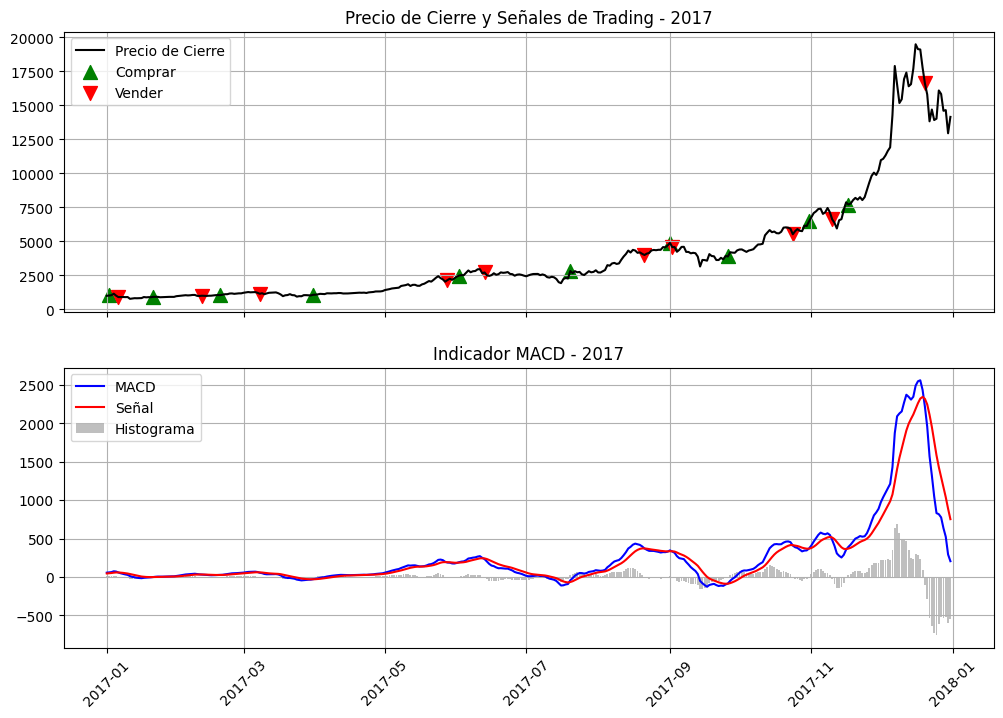

In [9]:
# Crear el gráfico
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Gráfico de precios con señales
ax1.plot(filtered_df.index, filtered_df['Close'], label='Precio de Cierre', color='black')

# Inicializar variables para las señales
buy_signals = []
sell_signals = []
last_signal = None

# Detectar señales de compra y venta
for i in range(1, len(filtered_df)):
    if filtered_df['macd_test'].iloc[i] == 1 and (last_signal is None or last_signal == 'sell'):
        buy_signals.append((filtered_df.index[i], filtered_df['Close'].iloc[i]))
        last_signal = 'buy'
    elif filtered_df['macd_test'].iloc[i] == 0 and last_signal == 'buy':
        sell_signals.append((filtered_df.index[i], filtered_df['Close'].iloc[i]))
        last_signal = 'sell'

# Convertir las señales a DataFrames
buy_signals = pd.DataFrame(buy_signals, columns=['Date', 'Close'])
sell_signals = pd.DataFrame(sell_signals, columns=['Date', 'Close'])

# Pintar las señales en el gráfico
ax1.scatter(buy_signals['Date'], buy_signals['Close'], marker='^', color='green', label='Comprar', alpha=1, s=100)
ax1.scatter(sell_signals['Date'], sell_signals['Close'], marker='v', color='red', label='Vender', alpha=1, s=100)

ax1.set_title(f'Precio de Cierre y Señales de Trading - {year}')
ax1.legend()
ax1.grid()

# Gráfico de MACD
ax2.plot(filtered_df.index, filtered_df['macd'], label='MACD', color='blue')
ax2.plot(filtered_df.index, filtered_df['macdSignal'], label='Señal', color='red')
ax2.bar(filtered_df.index, filtered_df['macdHist'], label='Histograma', color='gray', alpha=0.5)

ax2.set_title(f'Indicador MACD - {year}')
ax2.legend()
ax2.grid()

plt.xticks(rotation=45)
plt.show()

##### Referencias

- https://medium.com/coinmonks/4-step-profitable-trades-using-rsi-and-macd-indicators-a0fca6400fd2
- https://python-binance.readthedocs.io/en/latest/overview.html
